In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images/255

60000

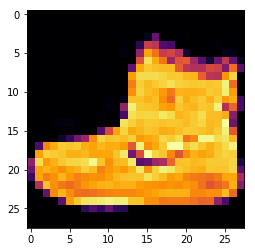

In [3]:
plt.imshow(train_images[0].reshape(28,28), cmap='inferno')
train_images.shape[0]

In [4]:
def generator(z,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        #Custon made Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        return output    

In [5]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        #Custon made Leaky Relu
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1,units=128)
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
    
        return output, logits  

In [6]:
real_images = tf.placeholder(tf.float32, shape=[None, 784])
z = tf.placeholder(tf.float32, shape=[None, 100])   #Random noise

In [7]:
G = generator(z)    #Generating from noise

In [8]:
D_outputs_real, D_logits_real = discriminator(real_images)
D_outputs_fake, D_logits_fake = discriminator(G, reuse=True)

In [9]:
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in, labels=labels_in))

In [10]:
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9) #0.9 is multiplied for 
                                                                        #better generalisability
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))
D_loss = D_real_loss + D_fake_loss
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

In [11]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [12]:
D_trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(D_loss, var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(G_loss, var_list=g_vars)

In [13]:
g_vars

[<tf.Variable 'gen/dense/kernel:0' shape=(100, 128) dtype=float32_ref>,
 <tf.Variable 'gen/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gen/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'gen/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gen/dense_2/kernel:0' shape=(128, 784) dtype=float32_ref>,
 <tf.Variable 'gen/dense_2/bias:0' shape=(784,) dtype=float32_ref>]

In [14]:
batch_size = 100
epochs = 100
init = tf.global_variables_initializer()
samples = []

In [15]:
with tf.Session() as sess:
    
    sess.run(init)
    

    for e in range(epochs):
        if e % 10 == 0:
            print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        sample_z = np.random.uniform(-1, 1, size=(1, 100))
        gen_sample = sess.run(generator(z ,reuse=True),feed_dict={z: sample_z})
        
        samples.append(gen_sample) #sample 
        num_batches = train_images.shape[0] // batch_size
        for i in range(num_batches):
            batch = train_images.reshape(train_images.shape[0], 784)
            batch_images = batch[i*batch_size:(i+1)*batch_size]
            batch_images = batch_images*2 - 1
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1, 1, size=(batch_size, 100))
            
            _ = sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            _ = sess.run(G_trainer, feed_dict={z: batch_z})

Currently on Epoch 1 of 100 total...
Currently on Epoch 11 of 100 total...
Currently on Epoch 21 of 100 total...
Currently on Epoch 31 of 100 total...
Currently on Epoch 41 of 100 total...
Currently on Epoch 51 of 100 total...
Currently on Epoch 61 of 100 total...
Currently on Epoch 71 of 100 total...
Currently on Epoch 81 of 100 total...
Currently on Epoch 91 of 100 total...


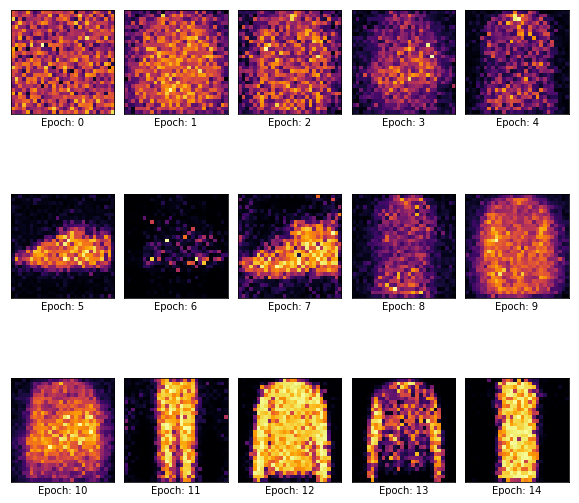

In [32]:
plt.figure(figsize=(10, 10))

for i in range(15):
    
    plt.subplots_adjust(wspace = 0.1, hspace=0.05)
    plt.subplot(3, 5, i+1)
    plt.xlabel("Epoch: {}".format(i))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(samples[i].reshape(28, 28), cmap='inferno')

## The random noise slowly taking the desired form is a treat to watch.